In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [3]:
df= data.copy()

In [4]:
my_vars=['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders','Transmission Type', 'Vehicle Style', 'highway MPG',
         'city mpg','MSRP']
df=df[my_vars]

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
    
df=df.fillna(0)

In [6]:
numerical_columns=list(df.dtypes[df.dtypes != 'object'].index)
numerical_columns.remove('msrp')
numerical_columns

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [7]:
categorical_columns

['make', 'model', 'transmission_type', 'vehicle_style']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [9]:
# Create a variable above_average
mean_msrp= df['msrp'].mean()
df['above_average']=np.where(df['msrp']> mean_msrp,1,0)
msrp_serie=df['msrp']
del df['msrp']

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

### Question 1

In [11]:
from sklearn.metrics import roc_auc_score

In [12]:
roc_auc_score(df_train['above_average'], df_train['engine_hp'])

0.9171031265539011

In [13]:
roc_auc_score(df_train['above_average'], df_train['engine_cylinders'])

0.766116490165669

In [14]:
roc_auc_score(df_train['above_average'], -df_train['highway_mpg'])

0.6330587871772013

In [15]:
roc_auc_score(df_train['above_average'], -df_train['city_mpg'])

0.6734244643245233

### Question 2

In [16]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [17]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [18]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [19]:
X_train.shape

(7148, 953)

In [20]:
X_val.shape

(2383, 953)

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, )
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [22]:
y_pred = model.predict_proba(X_val)[:, 1]

In [23]:
roc_auc_score(y_val, y_pred)

0.9761329930330412

### Question 3

In [24]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [25]:
def prec_rec_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        predict = (y_pred >= t)
        prec= precision_score(y_val, predict)
        rec=  recall_score(y_val, predict)
        f1= 2*prec*rec/(prec+rec)

        scores.append((t, prec, rec, f1))

    columns = ['threshold', 'precision', 'recall', 'f1']
    df_scores = pd.DataFrame(scores, columns=columns)
       
    return df_scores

In [26]:
df_plot = prec_rec_dataframe(y_val, y_pred)

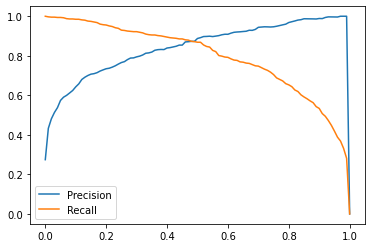

In [27]:
plt.plot(df_plot.threshold, df_plot['precision'], label='Precision')
plt.plot(df_plot.threshold, df_plot['recall'], label='Recall')
plt.legend()

In [28]:
df_plot[(df_plot['precision'] == df_plot['recall']) & (df_plot['precision'] !=0)]

,threshold,precision,recall,f1
48,0.48,0.873089,0.873089,0.873089


### Question 4

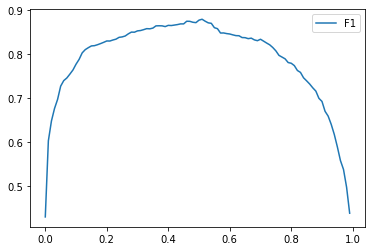

In [29]:
plt.plot(df_plot.threshold, df_plot['f1'], label='F1')
plt.legend()

In [30]:
df_plot[df_plot['f1'] == df_plot['f1'].max()]

,threshold,precision,recall,f1
51,0.51,0.89168,0.868502,0.879938


### Question 5

In [31]:
def train(df_train, y_train):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [32]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [33]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.980 +- 0.003


### Question 6

In [34]:
def train_tune(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [35]:
for C in [0.01, 0.1, 0.5, 10]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train_tune(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.979 +- 0.004
C=10 0.981 +- 0.003
